In [623]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


from tqdm import tqdm
import os

In [624]:
#using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 



In [625]:

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) #filtering only +ve and _ve revie discarding one with 3 score

In [626]:
# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0  #denotes negative 
    return 1      #denotes positive

In [627]:
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head()

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## DATA CLEANING 

In [628]:
#Deduplication 
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [629]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [630]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [631]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [632]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [633]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [634]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

##   Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [635]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [636]:
# remove urls from text 
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [637]:
#Removing tags 
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [638]:
#Replacing Phrases
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase



In [639]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [640]:
#remove words with numbers
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [641]:
#remove special character:
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [642]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=set(stopwords.words('english'))   


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [643]:
sno=nltk.stem.SnowballStemmer('english')

In [644]:
# Combining all the above steps 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Text'].values): 
    sentence = re.sub(r"http\S+", "", sentence)                                        #Remove urls from text 
    sentence = BeautifulSoup(sentence, 'lxml').get_text()                              #Removing tags 
    sentence = decontracted(sentence)                                                  #Replacing Phrases
    sentence = re.sub("\S*\d\S*", "", sentence).strip()                                #Remove words with numbers
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)                                     #Remove special character
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stop)  # we are removing the words from the stop words list
    sentence=(sno.stem(sentence.lower())).encode('utf8')                               #Stemming 
    preprocessed_reviews.append(sentence.strip())

100%|██████████| 4986/4986 [00:01<00:00, 2837.17it/s]


In [645]:
preprocessed_reviews[1500]

b'wow far two two star reviews one obviously idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies like combination order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however see taste like raw cookie dough soft however confusion yes stick together soft cookies tend individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second ord'

In [646]:
#Adding the cleantext column into data and removing text column
final["cleantext"]=preprocessed_reviews
final.drop(columns=["Text"],inplace=True)
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,cleantext
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,b'product available victor traps unreal course...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,b'used victor fly bait seasons ca beat great p...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,b'received shipment could hardly wait try prod...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,b'really good idea final product outstanding u...
2942,3204,B000084DVR,A1UGDJP1ZJWVPF,"T. Moore ""thoughtful reader""",1,1,1,1177977600,Good stuff!,b'glad cocker standard poodle puppy loves stuf...


1    4178
0     808
Name: Score, dtype: int64

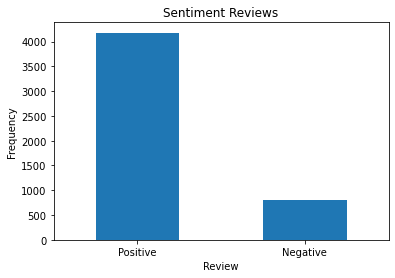

In [647]:
#Now cheking for class imbalance
values=final['Score'].value_counts()
values.plot(kind = 'bar', rot=0)
plt.title("Sentiment Reviews")
labels=['Positive','Negative']
plt.xticks(range(2),labels)
plt.xlabel("Review")
plt.ylabel("Frequency")
final['Score'].value_counts()

In [648]:

y=final["Score"]
x=final.drop(columns='Score')
print(x.shape)


(4986, 9)


In [649]:
#Train test split 
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y=train_test_split(x, y,test_size=0.3)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(3490, 9)
(1496, 9)
(3490,)
(1496,)


## Featurization

In [650]:
#BoW on train dataset 
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(train_x["cleantext"])
final_vector = count_vect.transform(train_x["cleantext"])
print("the type of count vectorizer ",type(final_vector))
print("the shape of out text BOW vectorizer ",final_vector.get_shape())
print("the number of unique words ", final_vector.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (3490, 11230)
the number of unique words  11230


In [651]:
#BoW on test dataset 

final_vec = count_vect.transform(test_x["cleantext"])
print("the type of count vectorizer ",type(final_vec))
print("the shape of out text BOW vectorizer ",final_vec.get_shape())
print("the number of unique words ", final_vec.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (1496, 11230)
the number of unique words  11230


In [652]:
#TF-IDF on train dataset 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(train_x["cleantext"])
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(train_x["cleantext"])
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'able find', 'absolute', 'absolutely', 'absolutely love', 'according', 'acid', 'across', 'active', 'actual']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (3490, 2124)
the number of unique words including both unigrams and bigrams  2124


In [653]:
#TF-IDF on test dataset 
final_tf_idftest = tf_idf_vect.transform(test_x["cleantext"])
print("the type of count vectorizer ",type(final_tf_idftest))
print("the shape of out text TFIDF vectorizer ",final_tf_idftest.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idftest.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (1496, 2124)
the number of unique words including both unigrams and bigrams  2124


## Modelling

In [654]:

from scipy import sparse
features=train_x[["HelpfulnessNumerator","HelpfulnessDenominator"]].values
train_X=sparse.hstack((features,final_tf_idf))
train_X.shape



(3490, 2126)

In [655]:
#USing synthetic oversampling. for train dataset
from imblearn.over_sampling import SMOTE
smote = SMOTE()
x_trains, y_trains = smote.fit_resample(train_X,train_y)
values=y_trains.value_counts()

print(values)


0    2920
1    2920
Name: Score, dtype: int64


Text(0, 0.5, 'Frequency')

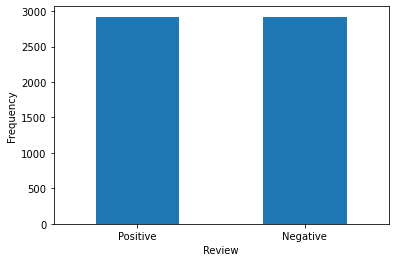

In [656]:
values.plot(kind = 'bar', rot=0)

labels=['Positive','Negative']
plt.xticks(range(2),labels)
plt.xlabel("Review")
plt.ylabel("Frequency")

In [657]:
from scipy import sparse
feature_test=test_x[["HelpfulnessNumerator","HelpfulnessDenominator"]].values
test_X=sparse.hstack((feature_test,final_tf_idftest))
test_X.shape

(1496, 2126)

In [658]:
#USing synthetic oversampling. for test dataset
x_tests,y_tests=smote.fit_resample(test_X,test_y)
values_test=y_tests.value_counts()
print(values_test)


0    1258
1    1258
Name: Score, dtype: int64


## Using Naive Bayes Classification 

In [659]:
from sklearn.naive_bayes import GaussianNB
NBC= GaussianNB()
XN_train=x_trains.todense()
NBC.fit(XN_train,y_trains)


GaussianNB()

In [660]:
predict_yn=NBC.predict(x_tests.toarray()) 

In [661]:
#Accuracy of the model 
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_tests,predict_yn)
accuracy

0.6248012718600954

## Measure of Performance 

In [662]:
conf_matrix = confusion_matrix(y_true=y_tests, y_pred=predict_yn)
conf_matrix

array([[ 556,  702],
       [ 242, 1016]], dtype=int64)

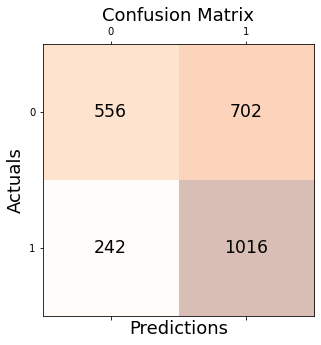

In [663]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [664]:
#Precision of the model 
from sklearn.metrics import precision_score
print('Precision: %.3f' % precision_score(y_tests, predict_yn))

Precision: 0.591


In [665]:
#Recall of the model
from sklearn.metrics import recall_score
print('Recall: %.3f' % recall_score(y_tests, predict_yn))


Recall: 0.808


In [666]:
#True Negative Rate /Specificity 
TNR=conf_matrix[0][0]/((conf_matrix[0][0]+conf_matrix[0][1]))
print("Specificity "+ str(TNR))


Specificity 0.4419713831478537


In [667]:
from sklearn.metrics import roc_curve, roc_auc_score
y_scoren = NBC.predict_proba(x_tests.toarray())[:,1]
false_positive_raten, true_positive_raten, thresholdn = roc_curve(y_tests, y_scoren)
print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_tests, y_scoren))

roc_auc_score for Logistic Regression:  0.6379015319443637


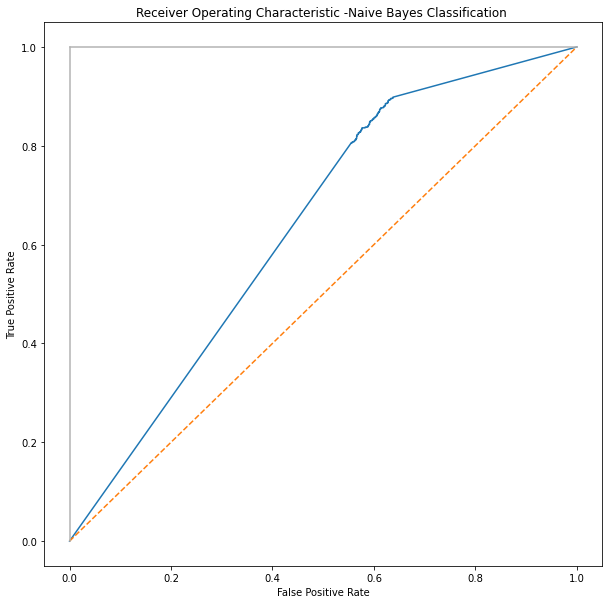

In [668]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic -Naive Bayes Classification ')
plt.plot(false_positive_raten, true_positive_raten)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Logistic Regression 


In [669]:
#Fitting the model 
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(x_trains,y_trains)


LogisticRegression()

In [670]:
predict_y=model.predict(x_tests)  #predicting the class by using logistic classifier

In [671]:
#Accuracy of the model 
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_tests,predict_y)
accuracy

0.8565182829888712

In [672]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
conf_matrix = confusion_matrix(y_true=y_tests, y_pred=predict_y)
conf_matrix

array([[1001,  257],
       [ 104, 1154]], dtype=int64)

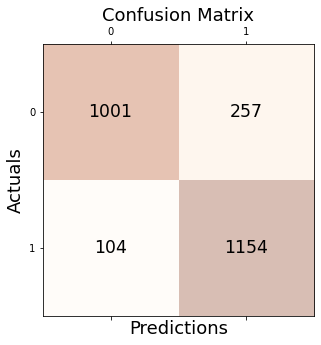

In [673]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [674]:
#Precision of the model 
print('Precision: %.3f' % precision_score(y_tests, predict_y))

Precision: 0.818


In [675]:
#Recall of the model
print('Recall: %.3f' % recall_score(y_tests, predict_y))

Recall: 0.917


In [676]:
#True Negative Rate /Specificity 
TNR=conf_matrix[0][0]/((conf_matrix[0][0]+conf_matrix[0][1]))
print("Specificity "+ str(TNR))


Specificity 0.7957074721780604


In [677]:
from sklearn.metrics import roc_curve, roc_auc_score
y_score = model.predict_proba(x_tests)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_tests, y_score)
print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_tests, y_score))

roc_auc_score for Logistic Regression:  0.942118612580597


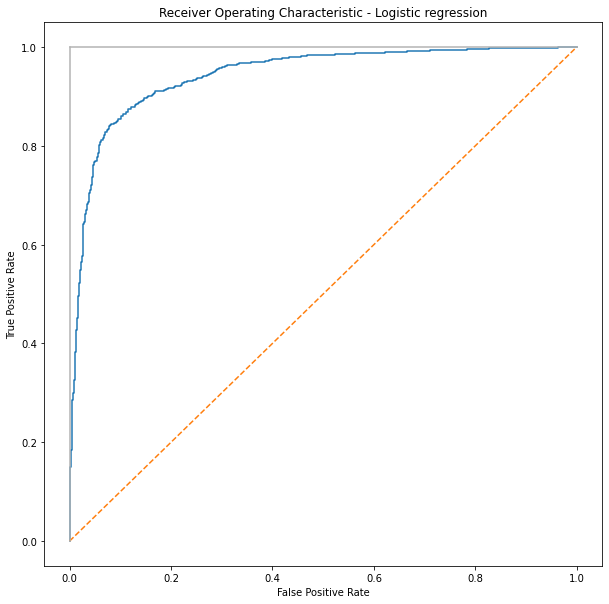

In [678]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()